In [11]:
from pathlib import Path
import math


import matplotlib.pyplot as plt
import numpy as np
import torch
from src.models.particle_filter import ParticleFilterMLP

## Get netoutput names

In [12]:
from src.models.normal import NormalDegradationModel as NModel
noise_names = NModel.get_state_names() 
netout_names = [p.replace('_raw','_noise') for p in noise_names] + ['tempered_correct']+['prior_correct']
n_outs = len(netout_names)

In [13]:
data_name = "DS03"
perform_name = "SmHPC"
device = "cpu" 

experiment_dir = Path('experiments')/data_name
pf_dir = experiment_dir/'pf_perform'/ perform_name

In [14]:
net = ParticleFilterMLP(state_dim=NModel.state_dim(),hidden_dims=[128, 128, 32])

ckpt = torch.load(pf_dir/'checkpoint.pt', map_location=device)
net.load_state_dict(ckpt['model_state'])


net = net.to(device)
net.eval()    # or net.train()

ParticleFilterMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=9, bias=True)
  )
)

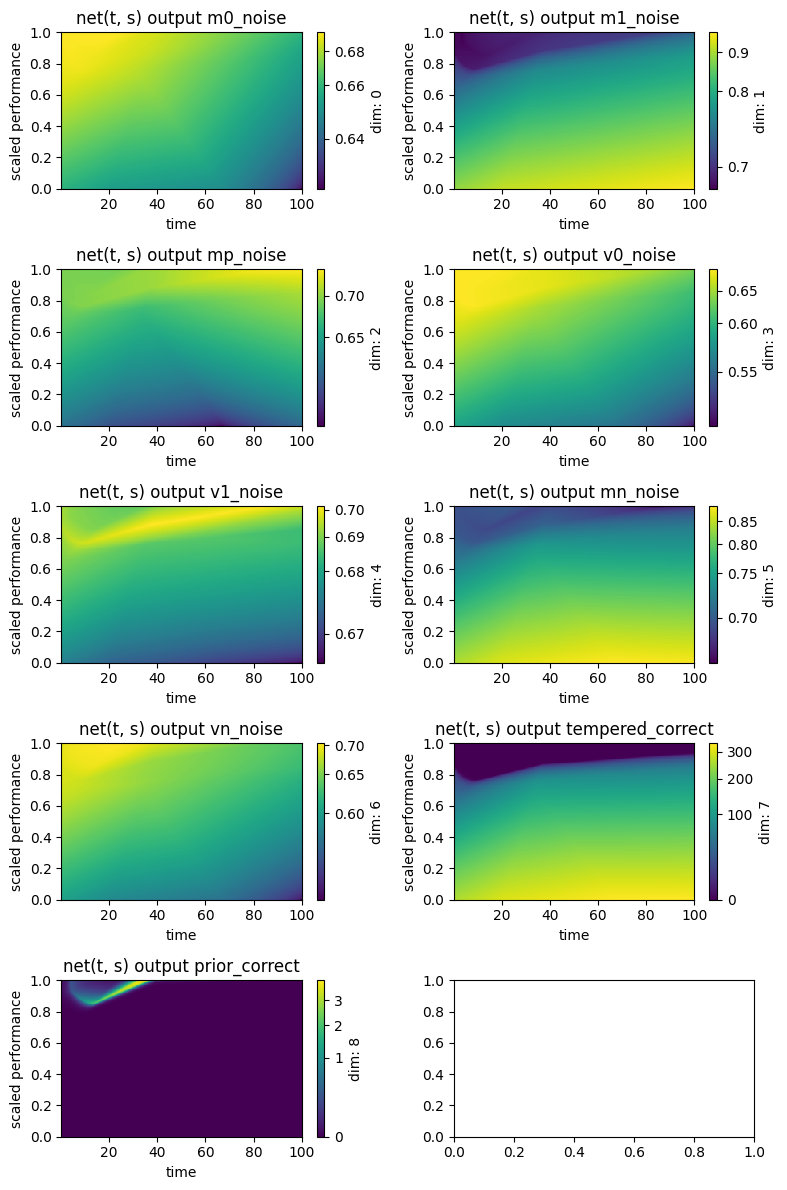

In [15]:
t_grid = np.linspace(0.1, 100, 300)
s_grid = np.linspace(0.0, 1.0, 200)

net.eval()

fig, axes = plt.subplots(math.ceil(n_outs/2), 2, figsize=(8, 12))
vmax = len(noise_names)*[None] +[None,None]
for i,name in enumerate(netout_names):
	net.plot_output(
		t=t_grid,
		s=s_grid,
		dim=i,
  		vmax=vmax[i],
		ax=axes[i//2, i%2],
		title=f"net(t, s) output {name}",
	)


plt.tight_layout()
plt.show()